#1 Setup and imports


In [40]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn beautifulsoup4 lxml requests -q
print("✓ Installation complete!")

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

print("="*80)
print("PREMIER LEAGUE 2025/2026 TOP 6 PREDICTION")
print("="*80)

✓ Installation complete!
PREMIER LEAGUE 2025/2026 TOP 6 PREDICTION


# 2. DATA COLLECTION

In [41]:
print("\n" + "="*80)
print("PHASE 1: COLLECTING HISTORICAL DATA (2020-2025)")
print("="*80)

# Collect historical teams data
seasons = [2024, 2023, 2022, 2021, 2020]  # These represent 2024/25, 2023/24, etc.
teams_data = []

print("\n[1/4] Collecting Historical Teams Data...")

for season in seasons:
    url = f"https://understat.com/league/EPL/{season}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'lxml')
        scripts = soup.find_all('script')

        for script in scripts:
            if script.string and 'teamsData' in script.string:
                strings = script.string
                ind_start = strings.index("JSON.parse('") + len("JSON.parse('")
                ind_end = strings.index("')", ind_start)
                json_data = strings[ind_start:ind_end]
                json_data = json_data.encode('utf-8').decode('unicode_escape')
                teams = json.loads(json_data)

                for team_id, team_info in teams.items():
                    matches = team_info['history']
                    team_dict = {
                        "Season": f"{season}/{season+1}",
                        "Team name": team_info['title'],
                        "Games Played": len(matches),
                        "Wins": sum([1 for m in matches if m['result'] == 'w']),
                        "Draws": sum([1 for m in matches if m['result'] == 'd']),
                        "Losses": sum([1 for m in matches if m['result'] == 'l']),
                        "Goals For": sum([m['scored'] for m in matches]),
                        "Goals Against": sum([m['missed'] for m in matches]),
                        "Points": sum([m['pts'] for m in matches]),
                        "xG": round(sum([float(m['xG']) for m in matches]), 1),
                        "xGa": round(sum([float(m['xGA']) for m in matches]), 1),
                    }
                    teams_data.append(team_dict)

                print(f"  ✓ {season}/{season+1} - {len(teams)} teams")
                break

        time.sleep(2)

    except Exception as e:
        print(f"  ✗ Error {season}: {e}")

teams_df = pd.DataFrame(teams_data)
teams_df = teams_df.sort_values(['Season', 'Points'], ascending=[True, False])
teams_df['Ranking'] = teams_df.groupby('Season')['Points'].rank(ascending=False, method='min').astype(int)
teams_df['Top 6 Label'] = (teams_df['Ranking'] <= 6).astype(int)

print(f"\n  Total historical teams: {len(teams_df)}")

# Collect historical players data
print("\n[2/4] Collecting Historical Players Data...")

players_data = []
for season in seasons:
    url = f"https://understat.com/league/EPL/{season}"

    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        scripts = soup.find_all('script')
        strings = scripts[3].string

        ind_start = strings.index("('")+2
        ind_end = strings.index("');")
        json_data = strings[ind_start:ind_end]
        json_data = json_data.encode('utf-8').decode('unicode_escape')
        data = json.loads(json_data)

        for player in data[:50]:
            player_info = {
                "Season": f"{season}/{season+1}",
                "name": player['player_name'],
                "Team name": player['team_title'],
                "Minutes played": player['time'],
                "Games played": player['games'],
                "Goals": player['goals'],
                "Assists": player['assists'],
                "xG": player['xG'],
                "xA": player['xA'],
                "Shots": player['shots'],
                "Key Passes": player['key_passes'],
                "npg": player['npg'],
                "npxG": player['npxG'],
            }
            players_data.append(player_info)

        print(f"  ✓ {season}/{season+1} players")

    except Exception as e:
        print(f"  ✗ Error {season}: {e}")

players_df = pd.DataFrame(players_data)

# Get player positions
print("\n[3/4] Getting Player Positions...")

try:
    url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(url)
    data = response.json()
    positions = {pos['id']: pos['singular_name'] for pos in data['element_types']}
    name_to_position = {}

    for player in data['elements']:
        full_name = f"{player['first_name']} {player['second_name']}".lower()
        name_to_position[full_name] = positions.get(player['element_type'], "Midfielder")

    def get_player_position(player_name):
        return name_to_position.get(player_name.lower(), "Midfielder")

    players_df['Position'] = players_df['name'].apply(get_player_position)

    def is_penalty_taker(player_name):
        for player in data['elements']:
            full_name = f"{player['first_name']} {player['second_name']}"
            if full_name.lower() == player_name.lower():
                order = player['penalties_order']
                return 1 if order and order > 0 else 0
        return 0

    players_df['Penalty Taker'] = players_df['name'].apply(is_penalty_taker)
    print("  ✓ Positions added")

except Exception as e:
    print(f"  ✗ Error: {e}")
    players_df['Position'] = 'Midfielder'
    players_df['Penalty Taker'] = 0

print("\n✓ Historical data collection complete!")



PHASE 1: COLLECTING HISTORICAL DATA (2020-2025)

[1/4] Collecting Historical Teams Data...
  ✓ 2024/2025 - 20 teams
  ✓ 2023/2024 - 20 teams
  ✓ 2022/2023 - 20 teams
  ✓ 2021/2022 - 20 teams
  ✓ 2020/2021 - 20 teams

  Total historical teams: 100

[2/4] Collecting Historical Players Data...
  ✓ 2024/2025 players
  ✓ 2023/2024 players
  ✓ 2022/2023 players
  ✓ 2021/2022 players
  ✓ 2020/2021 players

[3/4] Getting Player Positions...
  ✓ Positions added

✓ Historical data collection complete!


# 3. DATA CLEANING & PREPROCESSING

In [43]:
print("\n" + "="*80)
print("PHASE 2: FEATURE ENGINEERING (HISTORICAL)")
print("="*80)

# Clean players
numeric_cols = ['Minutes played', 'Games played', 'Goals', 'Assists', 'xG', 'xA',
                'Shots', 'Key Passes', 'npg', 'npxG']
for col in numeric_cols:
    players_df[col] = pd.to_numeric(players_df[col], errors='coerce')

players_df = players_df[players_df['Position'].isin(['Forward', 'Midfielder'])]
players_df = players_df[players_df['Minutes played'] > 1000]
players_df = players_df.dropna(subset=['name', 'Team name', 'Position'])

# Engineer player features
players_df['Goals per Game'] = players_df['Goals'] / players_df['Games played'].replace(0, 1)
players_df['Assists per Game'] = players_df['Assists'] / players_df['Games played'].replace(0, 1)
players_df['xG per Game'] = players_df['xG'] / players_df['Games played'].replace(0, 1)
players_df['xA per Game'] = players_df['xA'] / players_df['Games played'].replace(0, 1)
players_df['npxG per Game'] = players_df['npxG'] / players_df['Games played'].replace(0, 1)
players_df['Shots per Game'] = players_df['Shots'] / players_df['Games played'].replace(0, 1)
players_df['Key Passes per Game'] = players_df['Key Passes'] / players_df['Games played'].replace(0, 1)
players_df['Shot Conversion'] = players_df['Goals'] / players_df['Shots'].replace(0, 1)
players_df['xG Overperformance'] = players_df['Goals'] - players_df['xG']

# Clean teams
teams_df['Goals Difference'] = teams_df['Goals For'] - teams_df['Goals Against']
teams_df['xG Difference'] = teams_df['xG'] - teams_df['xGa']
teams_df['Win Ratio'] = teams_df['Wins'] / teams_df['Games Played'].replace(0, 1)
teams_df['Goal Efficiency'] = teams_df['Goals For'] / teams_df['xG'].replace(0, 1)
teams_df['Defensive Leakiness'] = teams_df['Goals Against'] / teams_df['xGa'].replace(0, 1)
teams_df['Attack Overperformance'] = teams_df['Goals For'] - teams_df['xG']
teams_df['Defense Overperformance'] = teams_df['xGa'] - teams_df['Goals Against']

print(f"  Historical players: {len(players_df)}")
print(f"  Historical teams: {len(teams_df)}")

# ============================================================================
# PHASE 3: COLLECT CURRENT SEASON DATA (2024/2025) FOR PREDICTION
# ============================================================================

print("\n" + "="*80)
print("PHASE 3: COLLECTING CURRENT SEASON DATA (2024/2025)")
print("="*80)

current_season = 2024
teams_2025_data = []
players_2025_data = []

print("\n[1/2] Collecting Current Season Teams Data...")

url = f"https://understat.com/league/EPL/{current_season}"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'lxml')
    scripts = soup.find_all('script')

    for script in scripts:
        if script.string and 'teamsData' in script.string:
            strings = script.string
            ind_start = strings.index("JSON.parse('") + len("JSON.parse('")
            ind_end = strings.index("')", ind_start)
            json_data = strings[ind_start:ind_end]
            json_data = json_data.encode('utf-8').decode('unicode_escape')
            teams = json.loads(json_data)

            for team_id, team_info in teams.items():
                matches = team_info['history']
                team_dict = {
                    "Season": "2025/2026",  # Predicting for next season
                    "Team name": team_info['title'],
                    "Games Played": len(matches),
                    "Wins": sum([1 for m in matches if m['result'] == 'w']),
                    "Draws": sum([1 for m in matches if m['result'] == 'd']),
                    "Losses": sum([1 for m in matches if m['result'] == 'l']),
                    "Goals For": sum([m['scored'] for m in matches]),
                    "Goals Against": sum([m['missed'] for m in matches]),
                    "Points": sum([m['pts'] for m in matches]),
                    "xG": round(sum([float(m['xG']) for m in matches]), 1),
                    "xGa": round(sum([float(m['xGA']) for m in matches]), 1),
                }
                teams_2025_data.append(team_dict)

            print(f"  ✓ Current season teams: {len(teams)}")
            break

    time.sleep(2)

except Exception as e:
    print(f"  ✗ Error: {e}")

print("\n[2/2] Collecting Current Season Players Data...")

try:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    scripts = soup.find_all('script')
    strings = scripts[3].string

    ind_start = strings.index("('")+2
    ind_end = strings.index("');")
    json_data = strings[ind_start:ind_end]
    json_data = json_data.encode('utf-8').decode('unicode_escape')
    data = json.loads(json_data)

    for player in data[:50]:
        player_info = {
            "Season": "2025/2026",
            "name": player['player_name'],
            "Team name": player['team_title'],
            "Minutes played": player['time'],
            "Games played": player['games'],
            "Goals": player['goals'],
            "Assists": player['assists'],
            "xG": player['xG'],
            "xA": player['xA'],
            "Shots": player['shots'],
            "Key Passes": player['key_passes'],
            "npg": player['npg'],
            "npxG": player['npxG'],
        }
        players_2025_data.append(player_info)

    print(f"  ✓ Current season players collected")

except Exception as e:
    print(f"  ✗ Error: {e}")

teams_2025_df = pd.DataFrame(teams_2025_data)
players_2025_df = pd.DataFrame(players_2025_data)

# Add positions to current season players
try:
    url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(url)
    data = response.json()
    positions = {pos['id']: pos['singular_name'] for pos in data['element_types']}
    name_to_position = {}

    for player in data['elements']:
        full_name = f"{player['first_name']} {player['second_name']}".lower()
        name_to_position[full_name] = positions.get(player['element_type'], "Midfielder")

    players_2025_df['Position'] = players_2025_df['name'].apply(
        lambda x: name_to_position.get(x.lower(), "Midfielder")
    )

    players_2025_df['Penalty Taker'] = players_2025_df['name'].apply(
        lambda player_name: 1 if any(
            p['first_name'].lower() + ' ' + p['second_name'].lower() == player_name.lower()
            and p['penalties_order'] and p['penalties_order'] > 0
            for p in data['elements']
        ) else 0
    )

except Exception as e:
    print(f"  Warning: {e}")
    players_2025_df['Position'] = 'Midfielder'
    players_2025_df['Penalty Taker'] = 0

# Clean and engineer features for 2025/2026 data
for col in numeric_cols:
    players_2025_df[col] = pd.to_numeric(players_2025_df[col], errors='coerce')

players_2025_df = players_2025_df[players_2025_df['Position'].isin(['Forward', 'Midfielder'])]
players_2025_df = players_2025_df[players_2025_df['Minutes played'] > 500]  # Lower threshold for current season
players_2025_df = players_2025_df.dropna(subset=['name', 'Team name', 'Position'])

# Engineer same features
players_2025_df['Goals per Game'] = players_2025_df['Goals'] / players_2025_df['Games played'].replace(0, 1)
players_2025_df['Assists per Game'] = players_2025_df['Assists'] / players_2025_df['Games played'].replace(0, 1)
players_2025_df['xG per Game'] = players_2025_df['xG'] / players_2025_df['Games played'].replace(0, 1)
players_2025_df['xA per Game'] = players_2025_df['xA'] / players_2025_df['Games played'].replace(0, 1)
players_2025_df['npxG per Game'] = players_2025_df['npxG'] / players_2025_df['Games played'].replace(0, 1)
players_2025_df['Shots per Game'] = players_2025_df['Shots'] / players_2025_df['Games played'].replace(0, 1)
players_2025_df['Key Passes per Game'] = players_2025_df['Key Passes'] / players_2025_df['Games played'].replace(0, 1)
players_2025_df['Shot Conversion'] = players_2025_df['Goals'] / players_2025_df['Shots'].replace(0, 1)
players_2025_df['xG Overperformance'] = players_2025_df['Goals'] - players_2025_df['xG']

teams_2025_df['Goals Difference'] = teams_2025_df['Goals For'] - teams_2025_df['Goals Against']
teams_2025_df['xG Difference'] = teams_2025_df['xG'] - teams_2025_df['xGa']
teams_2025_df['Win Ratio'] = teams_2025_df['Wins'] / teams_2025_df['Games Played'].replace(0, 1)
teams_2025_df['Goal Efficiency'] = teams_2025_df['Goals For'] / teams_2025_df['xG'].replace(0, 1)
teams_2025_df['Defensive Leakiness'] = teams_2025_df['Goals Against'] / teams_2025_df['xGa'].replace(0, 1)
teams_2025_df['Attack Overperformance'] = teams_2025_df['Goals For'] - teams_2025_df['xG']
teams_2025_df['Defense Overperformance'] = teams_2025_df['xGa'] - teams_2025_df['Goals Against']

print(f"\n  Current season players: {len(players_2025_df)}")
print(f"  Current season teams: {len(teams_2025_df)}")



PHASE 2: FEATURE ENGINEERING (HISTORICAL)
  Historical players: 246
  Historical teams: 100

PHASE 3: COLLECTING CURRENT SEASON DATA (2024/2025)

[1/2] Collecting Current Season Teams Data...
  ✓ Current season teams: 20

[2/2] Collecting Current Season Players Data...
  ✓ Current season players collected

  Current season players: 50
  Current season teams: 20


# 4. MERGE DATA & PREPARE FOR MODELING


In [44]:
print("\n" + "="*80)
print("PHASE 4: TRAINING MODEL ON HISTORICAL DATA")
print("="*80)

# Merge historical data
merged_historical = pd.merge(
    players_df,
    teams_df,
    on=['Team name', 'Season'],
    how='inner',
    suffixes=('_player', '_team')
)

print(f"\nHistorical merged data: {merged_historical.shape}")

# Encode positions
le_position = LabelEncoder()
merged_historical['Position_encoded'] = le_position.fit_transform(merged_historical['Position'])

# Remove leakage columns
leakage_columns = [
    'Top 6 Label', 'Points', 'Ranking', 'Wins', 'Draws', 'Losses',
    'Goals For', 'Goals Against', 'Goals Difference','Games Played',
    'Team name', 'Season', 'name', 'Position',
    'Goals', 'Assists'
]

columns_to_drop = [col for col in leakage_columns if col in merged_historical.columns]

X_train = merged_historical.drop(columns=columns_to_drop)
y_train = merged_historical['Top 6 Label']

# Handle missing values
X_train = X_train.fillna(X_train.median())

print(f"Training features: {X_train.shape}")
print(f"Training target distribution: Top 6: {y_train.sum()}, Not Top 6: {len(y_train) - y_train.sum()}")

# Train model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("\nTraining model...")
rf_model.fit(X_train, y_train)
print("✓ Model training complete!")


PHASE 4: TRAINING MODEL ON HISTORICAL DATA

Historical merged data: (242, 42)
Training features: (242, 27)
Training target distribution: Top 6: 111, Not Top 6: 131

Training model...
✓ Model training complete!


# 5. CREATE TRAIN/TEST SPLIT WITH PROPER INDEX TRACKING

In [45]:
print("\n" + "="*80)
print("PHASE 5: PREDICTING FOR 2025/2026 SEASON")
print("="*80)

# Merge 2025/2026 data
merged_2025 = pd.merge(
    players_2025_df,
    teams_2025_df,
    on=['Team name', 'Season'],
    how='inner',
    suffixes=('_player', '_team')
)

print(f"\n2025/2026 merged data: {merged_2025.shape}")

# Encode positions (using same encoder)
merged_2025['Position_encoded'] = merged_2025['Position'].apply(
    lambda x: le_position.transform([x])[0] if x in le_position.classes_ else 0
)

# Prepare features (same columns as training)
X_2025 = merged_2025[[col for col in X_train.columns if col in merged_2025.columns]]

# Add missing columns with 0
for col in X_train.columns:
    if col not in X_2025.columns:
        X_2025[col] = 0

# Reorder columns to match training
X_2025 = X_2025[X_train.columns]

# Handle missing values
X_2025 = X_2025.fillna(X_2025.median())

# Make predictions
print("\nMaking predictions for 2025/2026...")
y_pred_2025 = rf_model.predict(X_2025)
y_pred_proba_2025 = rf_model.predict_proba(X_2025)[:, 1]

# Create predictions DataFrame
predictions_2025 = pd.DataFrame({
    'Team': merged_2025['Team name'],
    'Predicted_Top_6': y_pred_2025,
    'Probability': y_pred_proba_2025
})

# Aggregate by team (take max probability)
predictions_2025 = predictions_2025.groupby('Team').agg({
    'Predicted_Top_6': 'max',
    'Probability': 'max'
}).reset_index()

predictions_2025 = predictions_2025.sort_values('Probability', ascending=False)
predictions_2025['Predicted_Rank'] = range(1, len(predictions_2025) + 1)

print("\n" + "="*80)
print("🏆 PREMIER LEAGUE 2025/2026 TOP 6 PREDICTIONS 🏆")
print("="*80)
print("\n" + predictions_2025.to_string(index=False))

# Show only Top 6
print("\n" + "="*80)
print("📊 PREDICTED TOP 6 FOR 2025/2026")
print("="*80)
top_6_predictions = predictions_2025[predictions_2025['Predicted_Top_6'] == 1].head(6)
for idx, row in top_6_predictions.iterrows():
    print(f"{row['Predicted_Rank']}. {row['Team']:25s} - {row['Probability']:.1%} confidence")



PHASE 5: PREDICTING FOR 2025/2026 SEASON

2025/2026 merged data: (50, 40)

Making predictions for 2025/2026...

🏆 PREMIER LEAGUE 2025/2026 TOP 6 PREDICTIONS 🏆

                   Team  Predicted_Top_6  Probability  Predicted_Rank
                Arsenal                1     0.998195               1
              Liverpool                1     0.993120               2
        Manchester City                1     0.971643               3
       Newcastle United                1     0.968358               4
            Aston Villa                1     0.912616               5
                Chelsea                1     0.912102               6
      Nottingham Forest                0     0.208086               7
      Manchester United                0     0.163211               8
              Brentford                0     0.155957               9
            Bournemouth                0     0.152713              10
         Crystal Palace                0     0.103340              11

# 6. TRAIN MODEL


CREATING VISUALIZATIONS


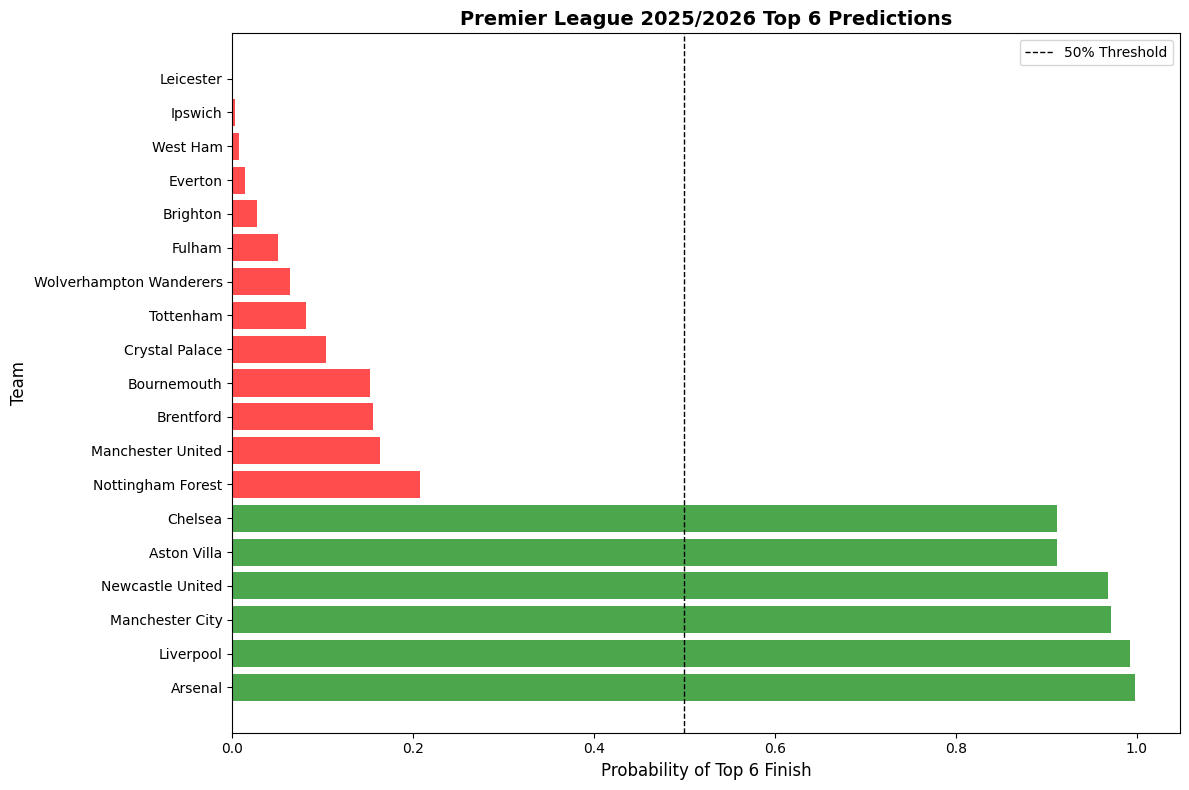

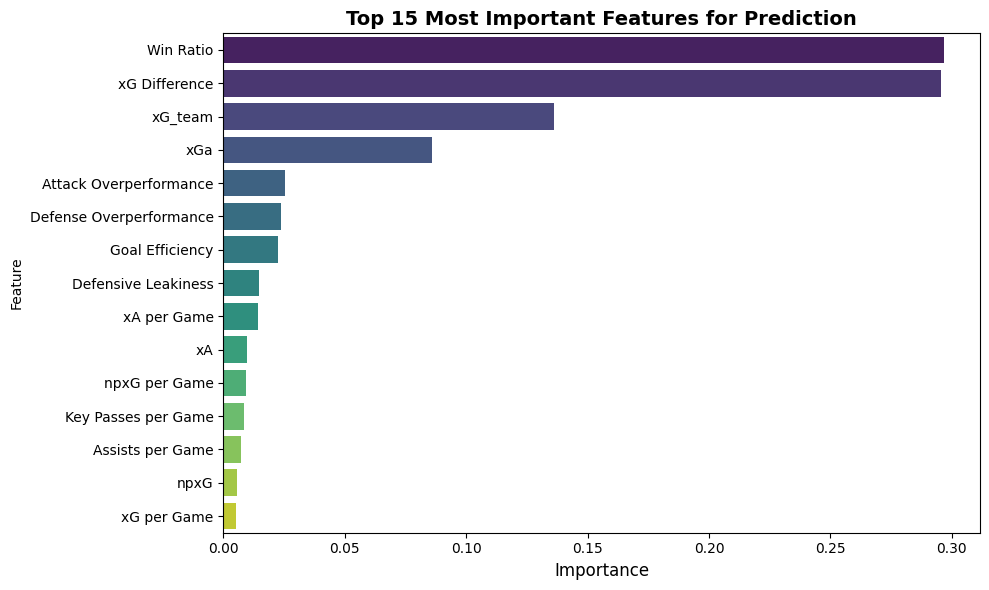


✓ ANALYSIS COMPLETE!

Key Insights:
  • Model trained on 242 historical player-seasons
  • Top 6 predictions made for 19 teams
  • Confidence scores range from 0.0% to 99.8%

Note: These predictions are based on current season (2024/25) performance
      projected forward to 2025/26. Actual results will depend on:
      - Summer transfers
      - Manager changes
      - Player injuries
      - Team form and momentum


In [46]:
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Prediction probabilities
plt.figure(figsize=(12, 8))
colors = ['green' if p == 1 else 'red' for p in predictions_2025['Predicted_Top_6']]
plt.barh(predictions_2025['Team'], predictions_2025['Probability'], color=colors, alpha=0.7)
plt.xlabel('Probability of Top 6 Finish', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.title('Premier League 2025/2026 Top 6 Predictions', fontsize=14, fontweight='bold')
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='50% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Most Important Features for Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE!")
print("="*80)
print("\nKey Insights:")
print(f"  • Model trained on {len(X_train)} historical player-seasons")
print(f"  • Top 6 predictions made for {len(predictions_2025)} teams")
print(f"  • Confidence scores range from {predictions_2025['Probability'].min():.1%} to {predictions_2025['Probability'].max():.1%}")
print("\nNote: These predictions are based on current season (2024/25) performance")
print("      projected forward to 2025/26. Actual results will depend on:")
print("      - Summer transfers")
print("      - Manager changes")
print("      - Player injuries")
print("      - Team form and momentum")
print("="*80)